# Лабораторная работа №5
### Выполнила Рындина Валерия, M33351

In [37]:
import pandas as pd

def normalize(data):
    for col in data.columns :
        if data[col].dtype.str == '<f8':
            min_val = min(data[col])
            max_val = max(data[col])
            data[col] = data[col].apply(lambda x: (x - min_val) / (max_val - min_val) if max_val != min_val else 0.0)

def get_data(file_path, weight=lambda _: 1):
    data = pd.read_csv(file_path)
    normalize(data)
    data['class'] = data['class'].apply(lambda x: 0 if x == 'P' else 1)
    data['weight'] = [weight(len(data))] * len(data)

    return data

In [23]:
from collections import defaultdict
import numpy as np


def entropy(p):
    return - (p[0] * np.log2(p[0]) if p[0] > 0 else 0) \
           - (p[1] * np.log2(p[1]) if p[1] > 0 else 0)

def predicates(n, feature):
    return lambda x: x[feature] > n, lambda x: x[feature] <= n

def get_best_rule(s):
    cnt = defaultdict(lambda: 0)
    sum_s = 0

    for _, obj in s.iterrows():
        cnt[obj['class']] += obj.weight
        sum_s += obj.weight

    res = []

    for feature in ['x', 'y']:
        sorted_s = s.sort_values(by=feature)

        cnt_left = defaultdict(lambda: 0)
        cnt_right = cnt.copy()
        sum_left, sum_right = 0, sum_s

        p_s = [cnt[0] / sum_s, cnt[1] / sum_s]
        branching_criteria = []

        for _, obj in sorted_s.iterrows():
            class_id = obj['class']
            weight = obj.weight

            cnt_left[class_id] += weight
            cnt_right[class_id] -= weight

            sum_left += weight
            sum_right -= weight

            p_left = [cnt_left[0] / sum_s, cnt_left[1] / sum_s]
            p_right = [cnt_right[0] / sum_s, cnt_right[1] / sum_s]

            branching_criteria.append(entropy(p_s)
                                      - (sum_left / sum_s) * entropy(p_left)
                                      - (sum_right / sum_s) * entropy(p_right))
        res.append([sorted_s.iloc[np.argmax(branching_criteria)][feature], feature, np.max(branching_criteria)])

    ind = 0 if res[0][2] > res[1][2] else 1
    return predicates(res[ind][0], res[ind][1])

In [38]:
class Node:
    def __init__(self, depth=0, max_depth=None):
        self.object = None

        self.rule = None
        self.left_tree = None
        self.right_tree = None

        self.max_depth = max_depth
        self.depth = depth

    def fit(self, s):
        cnt = s['class'].value_counts()

        if self.max_depth is not None and self.depth == self.max_depth:
            self.object = cnt.index[0]
            return

        if len(cnt) == 1:
            self.object = cnt.index[0]
            return

        best_rule = get_best_rule(s)

        self.rule = best_rule[0]
        left, right = s[best_rule[0]], s[best_rule[1]]

        if len(left) == 0 or len(right) == 0:
            self.object = cnt.index[0]
            return

        self.left_tree = Node(self.depth + 1, self.max_depth)
        self.left_tree.fit(left)

        self.right_tree = Node(self.depth + 1, self.max_depth)
        self.right_tree.fit(right)

    def predict(self, obj):
        if self.object is not None:
            return self.object
        if self.rule(obj):
            return self.left_tree.predict(obj)
        return self.right_tree.predict(obj)

In [25]:
import collections
import random


class RandomForest:
    def __init__(self):
        self.forest = None

    def fit(self, data):
        self.forest = []
        for i in range(0, 100):
            s = pd.DataFrame([])
            for j in range(0, len(data)):
                ind = random.randint(0, len(data) - 1)
                s = pd.concat([s, data.iloc[ind]], ignore_index=True, axis=1)
            s = s.T
            root = Node()
            root.fit(s)
            self.forest.append(root)

    def predict(self, obj):
        votes = list(map(lambda tree: tree.predict(obj), self.forest))
        return collections.Counter(votes).most_common()[0][0]

In [31]:
from matplotlib import pyplot as plt


def draw_plot(title, data, clf):
    plt.title(title)
    min_x1, max_x1 = data['x'].min(), data['x'].max()
    min_x2, max_x2 = data['y'].min(), data['y'].max()
    dx1 = max_x1 - min_x1
    dx2 = max_x2 - min_x2
    step1 = 10
    step2 = 30
    for x1 in np.arange(min_x1 - dx1 / step1, max_x1 + dx1 / step1, dx1 / step2):
        for x2 in np.arange(min_x2 - dx2 / step1, max_x2 + dx2 / step1, dx2 / step2):
            z = clf(pd.Series({'x': x1, 'y': x2}, index=['x', 'y']))
            c = 'w'
            c = 'lightcoral' if z == 0 else c
            c = 'lavenderblush' if z == 1 else c
            plt.scatter(x1, x2, color=c, s=150, marker='s')
    objects = data.drop(columns='class')
    target = data['class']
    for i in range(len(data)):
        features, label = objects.iloc[i], target[i]
        c = 'orchid' if label == 1 else 'red'
        plt.scatter(features['x'], features['y'], color=c, s=10)
    plt.show()

In [26]:
def get_accuracy(classifier, data):
    counter = 0
    for _, obj in data.iterrows():
        target = obj['class']
        predicted = classifier(obj)
        counter += (predicted == target)
    return counter / len(data)

In [33]:
def get_random_forest(file_name):
    dt = get_data(file_name)

    forest = RandomForest()
    forest.fit(dt)

    print(get_accuracy(forest.predict, dt))
    draw_plot('Random Forest', dt, forest.predict)

0.8898305084745762


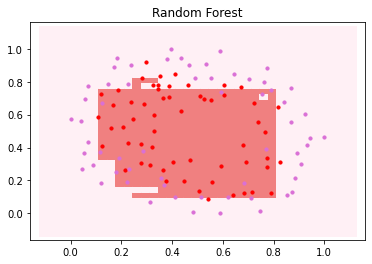

In [34]:
get_random_forest('data/chips.csv')

0.9144144144144144


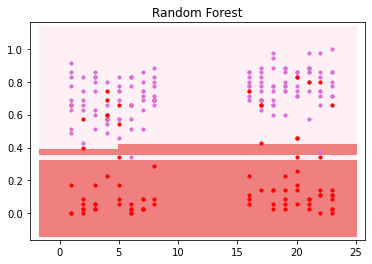

In [35]:
get_random_forest('data/geyser.csv')

In [39]:
def get_N(data, tree):
    result = 0
    for _, obj in data.iterrows():
        target = 1 if obj['class'] == 0 else -1
        predicted = 1 if tree.predict(obj) == 0 else -1
        result += obj.weight * (target * predicted < 0)
    return result

def compose(trees, b):
    def f(x):
        predicted = 0
        for t in range(len(b)):
            predicted += b[t] * (1 if trees[t].predict(x) == 0 else -1)
        return 0 if np.sign(predicted) == 1 else 1

    return f

In [43]:
def adaBoost(data, max_depth=None, T=55):
    b = []
    trees = []
    steps = {1, 2, 3, 5, 8, 13, 21, 34, 55}
    results = []

    for t in range(T):
        tree = Node(max_depth=max_depth)
        tree.fit(data)
        trees.append(tree)

        N = get_N(data, tree)
        alpha_i = N if (N == 0) | (N == 1) else 0.5 * np.log((1 - N) / N)

        b.append(alpha_i)
        new_w = []
        for i, obj in data.iterrows():
            y = 1 if obj['class'] == 0 else -1
            predicted = 1 if tree.predict(obj) == 0 else -1
            new_w.append(obj.weight * np.exp(-b[t] * y * predicted))

        data.weight = new_w
        weight_sum = np.sum(data.weight)
        data.weight = data.weight.apply(lambda w: w / weight_sum)

        if t + 1 in steps:
            current_classifier = compose(trees, b)
            accuracy = get_accuracy(current_classifier, data)
            results.append((t + 1, accuracy, current_classifier))
    return compose(trees, b), results

In [41]:
def get_adaboost(file_path):
    dt = get_data(file_path, lambda x: 1 / x)

    adaBoos_clf, res = adaBoost(dt, max_depth=2, T=55)
    for k, acc, clf in res:
        draw_plot('max_depth = {}, step = {}, accuracy = {}'.format(2, k, acc), dt, clf)

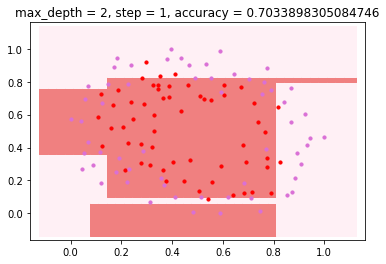

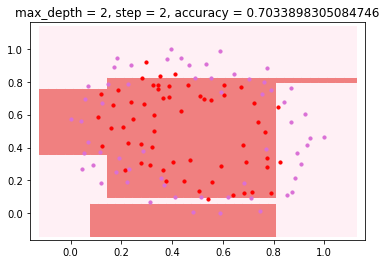

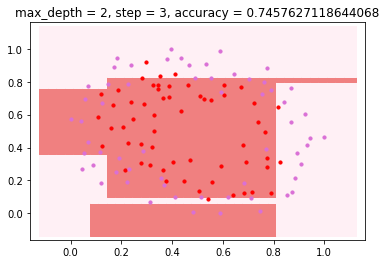

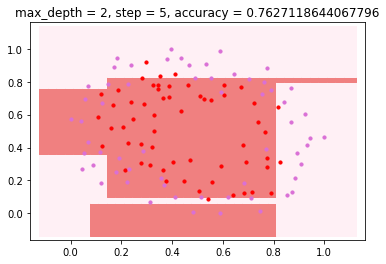

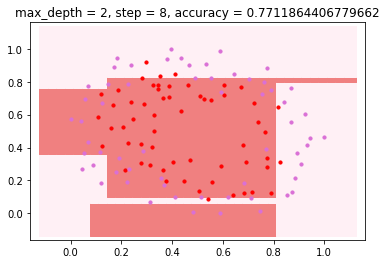

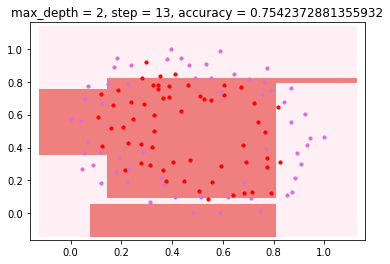

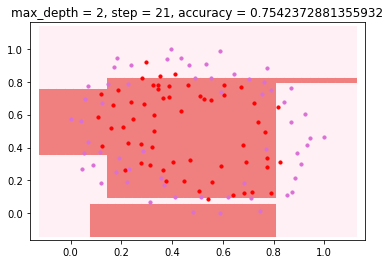

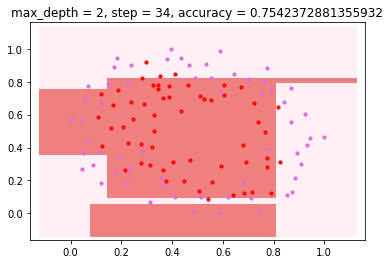

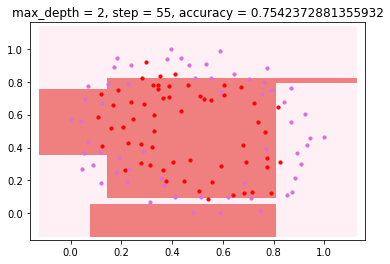

In [44]:
get_adaboost('data/chips.csv')

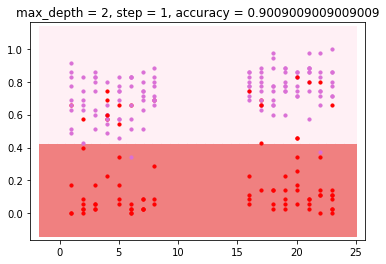

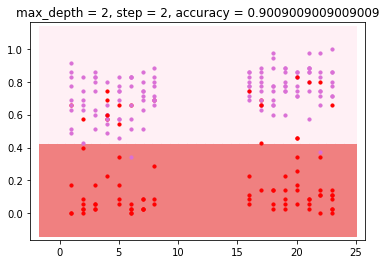

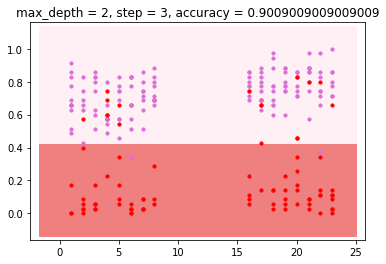

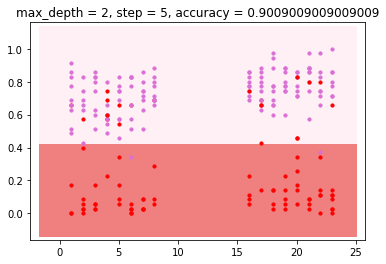

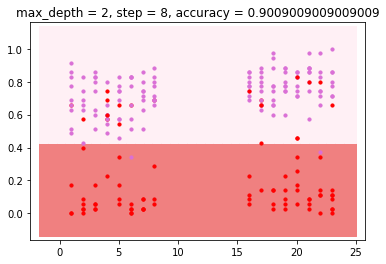

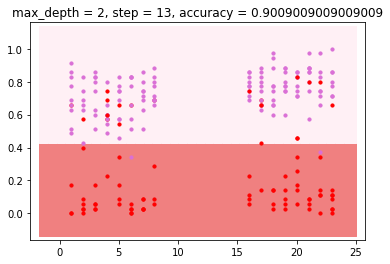

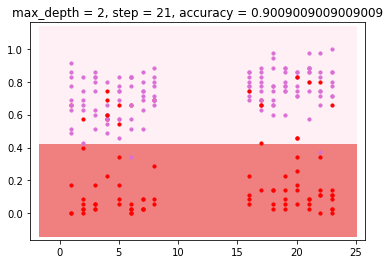

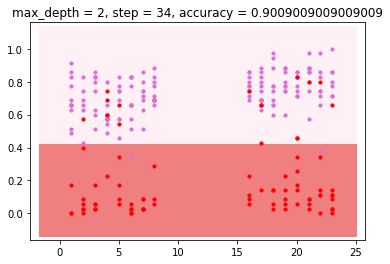

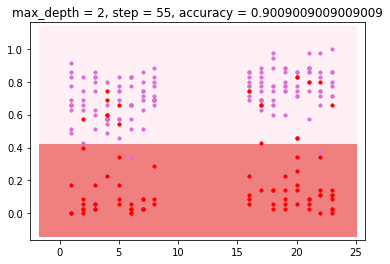

In [45]:
get_adaboost('data/geyser.csv')

In [48]:
from sklearn.model_selection import KFold

def kfold_validate(file_path):
    kf = KFold(n_splits=5, shuffle=True)
    max_depths = [1, 2, 3]
    steps = [1, 2, 3, 5, 8, 13, 21, 34, 55]
    ys = [[] for _ in range(len(max_depths))]
    for depth in max_depths:
        scores = {step: [] for step in steps}
        data = get_data(file_path, lambda x: 1 / x)

        for train_index, test_index in kf.split(data):
            data_train, data_test = pd.DataFrame(data.iloc[train_index]), pd.DataFrame(data.iloc[test_index])
            _, boost_result = adaBoost(data_train, max_depth=depth)

            for step, score, _ in boost_result:
                scores[step].append(score)
        for step in steps:
            score = np.mean(scores[step])
            ys[depth - 1].append(score)
    for depth in max_depths:
        plt.plot(steps, ys[depth - 1], label='max_depth = {}'.format(depth))

    plt.legend(loc='lower center')
    plt.xlabel('steps')
    plt.ylabel('accuracy')
    plt.show()

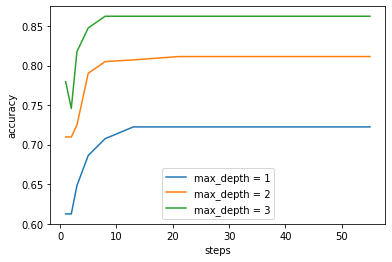

In [49]:
kfold_validate('data/chips.csv')

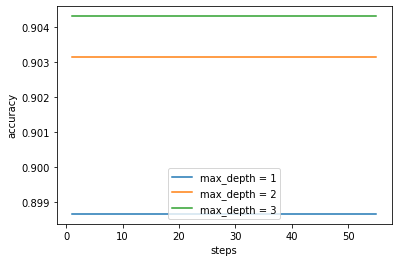

In [50]:
kfold_validate('data/geyser.csv')